In [1]:
import pandas_datareader as pdr

In [3]:
df = pdr.get_data_tiingo('NFTY', api_key = '8b4dc8427082d9ecb180cb2840316df12aa25f67')

In [5]:
df.to_csv('/content/drive/MyDrive/Stock Prediction/Notebooks/NFTY.csv')

In [6]:
df.tail()

close     high  ...  divCash  splitFactor
symbol date                                         ...                      
NFTY   2021-06-28 00:00:00+00:00  45.1300  45.1300  ...      0.0          1.0
       2021-06-29 00:00:00+00:00  45.1158  45.1200  ...      0.0          1.0
       2021-06-30 00:00:00+00:00  44.8530  44.9071  ...      0.0          1.0
       2021-07-01 00:00:00+00:00  44.7681  45.0745  ...      0.0          1.0
       2021-07-02 00:00:00+00:00  44.9975  44.9975  ...      0.0          1.0

[5 rows x 12 columns]

In [7]:
import pandas as pd

In [8]:
df1 = df.reset_index()['close']


In [9]:
df1.head()

0    39.03
1    37.84
2    37.63
3    38.10
4    37.83
Name: close, dtype: float64

In [10]:
len(df1)

809

In [11]:
import matplotlib.pyplot as plt

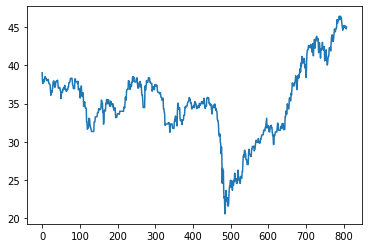

In [12]:
plt.plot(df1)

LSTM is sensitive to scale of data, so we apply MinMax Scaler

In [13]:
import numpy as np

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [16]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [17]:
df1.shape

(809, 1)

In [18]:
 training_size = int(len(df1) * 0.65)
 test_size = len(df1) - training_size
 train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]

In [19]:
import numpy as np

def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step -1):
    a = dataset[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  
  return np.array(dataX), np.array(dataY)

In [20]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [21]:
print(X_test.shape), print(y_test.shape)

(183, 100)
(183,)


(None, None)

In [22]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Creating a stacked LSTM Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [24]:
model = Sequential()
model.add(LSTM(256, return_sequences=False, input_shape = (100, 1)))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 8)                 2056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 266,257
Trainable params: 266,257
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 25, batch_size = 64, verbose = 2) 

Epoch 1/25
7/7 - 5s - loss: 0.0900 - mae: 0.2419 - val_loss: 0.0094 - val_mae: 0.0881
Epoch 2/25
7/7 - 3s - loss: 0.0095 - mae: 0.0868 - val_loss: 0.0148 - val_mae: 0.1124
Epoch 3/25
7/7 - 3s - loss: 0.0037 - mae: 0.0488 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 4/25
7/7 - 3s - loss: 0.0027 - mae: 0.0395 - val_loss: 0.0123 - val_mae: 0.1017
Epoch 5/25
7/7 - 3s - loss: 0.0026 - mae: 0.0407 - val_loss: 0.0029 - val_mae: 0.0468
Epoch 6/25
7/7 - 3s - loss: 0.0021 - mae: 0.0318 - val_loss: 0.0029 - val_mae: 0.0467
Epoch 7/25
7/7 - 3s - loss: 0.0017 - mae: 0.0311 - val_loss: 0.0052 - val_mae: 0.0645
Epoch 8/25
7/7 - 3s - loss: 0.0016 - mae: 0.0285 - val_loss: 0.0019 - val_mae: 0.0369
Epoch 9/25
7/7 - 3s - loss: 0.0015 - mae: 0.0270 - val_loss: 0.0030 - val_mae: 0.0483
Epoch 10/25
7/7 - 3s - loss: 0.0014 - mae: 0.0273 - val_loss: 0.0020 - val_mae: 0.0389
Epoch 11/25
7/7 - 3s - loss: 0.0013 - mae: 0.0260 - val_loss: 0.0018 - val_mae: 0.0364
Epoch 12/25
7/7 - 3s - loss: 0.0012 - mae: 0.0249 - 

## Prediction and checking performance metrics

In [27]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [28]:
train_predict.shape


(424, 1)

In [29]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

#### Calculate RMSE

In [30]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

33.34534752024764

In [31]:
math.sqrt(mean_squared_error(y_test, test_predict))

39.49048788383449

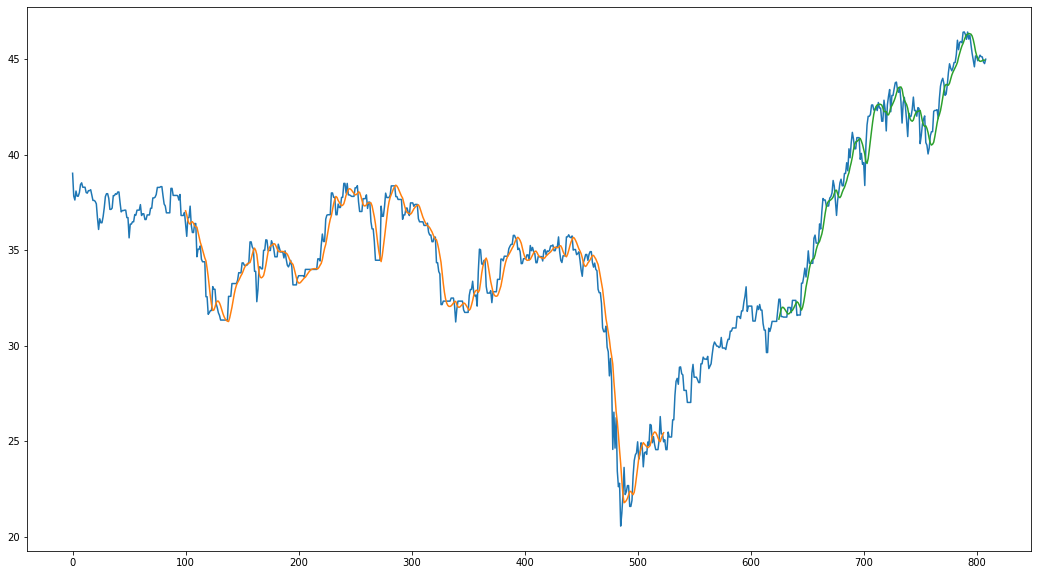

In [32]:
look_back = 100
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift Test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1:len(df1) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [33]:
len(test_data)


284

In [38]:
x_input=test_data[183:].reshape(1,-1)
x_input.shape

(1, 101)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [40]:
temp_input


[0.8522536529521423,
 0.8419774286620412,
 0.8419774286620412,
 0.8479451419023971,
 0.8408171474098656,
 0.8571655102530187,
 0.8459223849194377,
 0.8459223849194377,
 0.8193016653903573,
 0.8193016653903573,
 0.8617989000533728,
 0.8434007069980431,
 0.7996271629576341,
 0.8524199599316207,
 0.8698241787142538,
 0.8833839989480117,
 0.8384540412596013,
 0.8713712203838211,
 0.8713750879879949,
 0.8850586715553181,
 0.8972841683490747,
 0.8984444496012498,
 0.8819181769660966,
 0.877725694041569,
 0.8876228931226262,
 0.8593816474446738,
 0.8155810301750477,
 0.8566433836895397,
 0.8675036162099026,
 0.8479722151316145,
 0.8209415295600988,
 0.788213863040401,
 0.8355107944832494,
 0.8278452030105432,
 0.8296126981180236,
 0.8437526589778694,
 0.8680837568359903,
 0.8408094122015177,
 0.8411420261604745,
 0.8294309207218495,
 0.8468119338794391,
 0.8450715120011758,
 0.7738921247843811,
 0.7905382931489258,
 0.813248864858175,
 0.8234129286272325,
 0.8299878557228939,
 0.7760463803092

In [41]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):

        # print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.84197743 0.84197743 0.84794514 0.84081715 0.85716551 0.84592238
 0.84592238 0.81930167 0.81930167 0.8617989  0.84340071 0.79962716
 0.85241996 0.86982418 0.883384   0.83845404 0.87137122 0.87137509
 0.88505867 0.89728417 0.89844445 0.88191818 0.87772569 0.88762289
 0.85938165 0.81558103 0.85664338 0.86750362 0.84797222 0.82094153
 0.78821386 0.83551079 0.8278452  0.8296127  0.84375266 0.86808376
 0.84080941 0.84114203 0.82943092 0.84681193 0.84507151 0.77389212
 0.79053829 0.81324886 0.82341293 0.82998786 0.77604638 0.77081351
 0.75301867 0.76481873 0.78976477 0.79804145 0.79804145 0.83935519
 0.8411691  0.8411691  0.84272388 0.82453067 0.86449075 0.89027994
 0.90068766 0.90617579 0.89554375 0.87168063 0.87405921 0.89244966
 0.91748853 0.93553091 0.92650779 0.92134453 0.92728131 0.93793656
 0.93816474 0.95406833 0.98314498 0.96403902 0.978821   0.98052275
 0.97792758 0.99936185 1.         0.99513455 0.98507878 0.99977568
 0.98546554 0.99347535 0.97395942 0.95647398 0.943

In [42]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [43]:
len(df1)


809

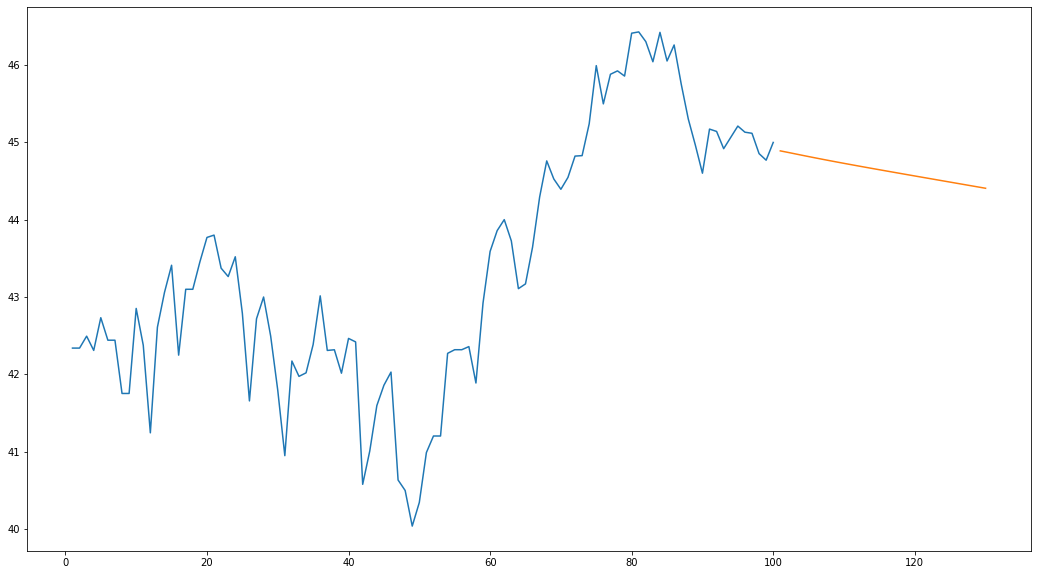

In [44]:
plt.figure(figsize=(18, 10))
plt.plot(day_new,scaler.inverse_transform(df1[709:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

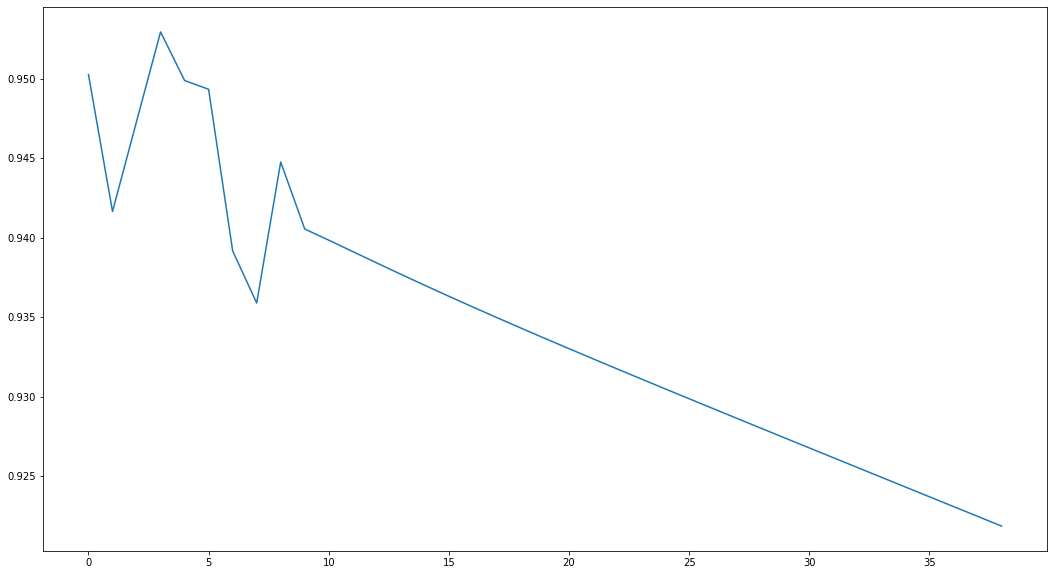

In [46]:
plt.figure(figsize=(18, 10))
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[800:])

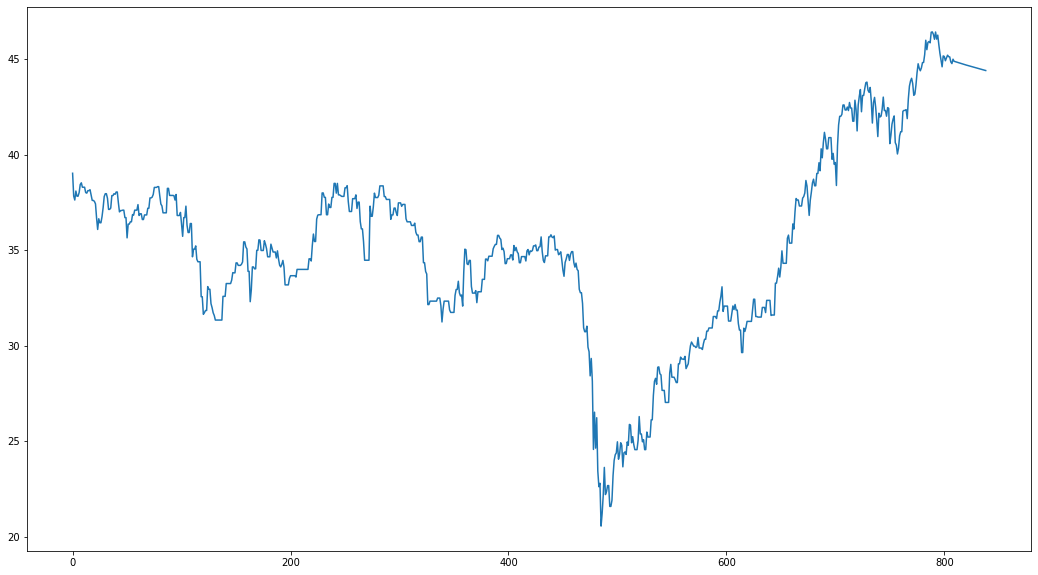

In [47]:
plt.figure(figsize=(18, 10))
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)